In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from networks import SwinUnet
from networks.misc import TransUnet, TRANSUNET_CONFIGS
from modules import *

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
CLASSES = 3
CLASS_WEIGHTS = None
LR = 1e-4
NUM_WORKERS = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PIN_MEMORY = True if DEVICE == 'cuda' else False

TRAIN_IMAGES_DIR = ['../data/ORIGA-cropped/TrainImages']
TRAIN_MASKS_DIR = ['../data/ORIGA-cropped/TrainMasks']
VAL_IMAGES_DIR = ['../data/ORIGA-cropped/TestImages']
VAL_MASKS_DIR = ['../data/ORIGA-cropped/TestMasks']

train_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation=cv.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=1.0),
    # A.CLAHE(p=1.0, clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    # A.RandomBrightnessContrast(p=0.5),
    # A.GridDistortion(p=0.5, border_mode=cv.BORDER_CONSTANT),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, interpolation=cv.INTER_AREA),
    # A.CLAHE(p=1.0, clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True),
    ToTensorV2(),
])

train_loader = load_dataset(
    TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, train_transform,
    BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle=True,
)
val_loader = load_dataset(
    VAL_IMAGES_DIR, VAL_MASKS_DIR, val_transform,
    BATCH_SIZE, NUM_WORKERS, PIN_MEMORY, shuffle=False,
)

Loaded dataset with 325 samples in 82 batches.
Loaded dataset with 325 samples in 82 batches.


In [3]:
IN_CHANNELS = 3
OUT_CHANNELS = CLASSES

config = TRANSUNET_CONFIGS['ViT-B_16'](CLASSES)
config.n_classes = CLASSES
config.n_skip = 0
# model = TransUnet(config, in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, img_size=IMAGE_SIZE).to(DEVICE)

model = SwinUnet(
    in_channels=IN_CHANNELS, out_channels=OUT_CHANNELS, img_size=IMAGE_SIZE, patch_size=4,
    embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24], window_size=7,
    mlp_ratio=4., qkv_bias=True, qk_scale=None, drop_rate=0.1, drop_path_rate=0.1,
    ape=True, patch_norm=True, use_checkpoint=False,
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

# criterion = nn.CrossEntropyLoss()
criterion = ComboLoss(num_classes=CLASSES, class_weights=CLASS_WEIGHTS)

C:\Users\ASUS\PycharmProjects\DP-GlaucomaSegmentation\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Train the model
NUM_EPOCHS = 5

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}')

    model.train()
    train_loss = 0.0
    for batch_idx, (images, masks) in enumerate(tqdm(train_loader)):
        images = images.to(DEVICE).float()
        masks = masks.to(DEVICE).long()

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(tqdm(val_loader)):
            images = images.to(DEVICE).float()
            masks = masks.to(DEVICE).long()

            outputs = model(images)
            loss = criterion(outputs, masks)

            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

torch.save(model, './models/swinunet.pth')
print('Model saved')

Model SwinUnet


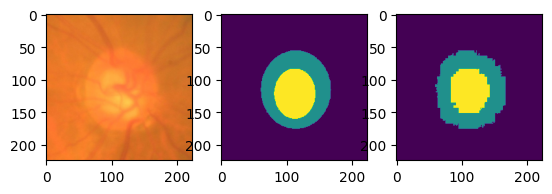

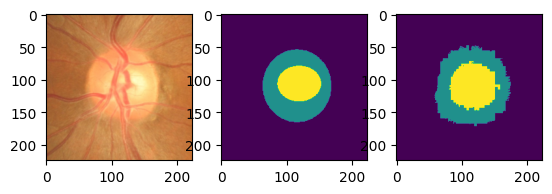

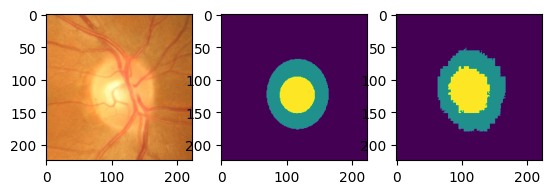

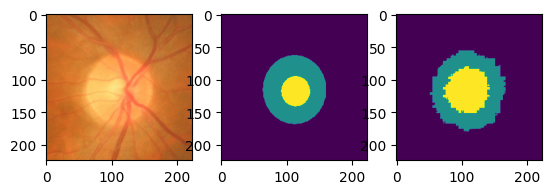

In [9]:
# Test the model
print('Model', model.__class__.__name__)
model.eval()
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(val_loader):
        images = images.to(DEVICE).float()
        masks = masks.to(DEVICE).long()

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for i in range(images.shape[0]):
            fig, ax = plt.subplots(1, 3)
            ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy() / 255.0)
            ax[1].imshow(masks[i].cpu().numpy())
            ax[2].imshow(preds[i].cpu().numpy())
            plt.show()

        break